### Libraries

In [1]:
import os
import json
import pandas as pd
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.interpolate import make_interp_spline
import subprocess

### Load data

In [2]:
df = pd.read_csv('summary_results.csv', index_col = 'Unnamed: 0')
df.head()

,beta,gamma,clipscore,refclipscore
0,0.00,5,0.862194,0.833905
1,0.00,10,0.899629,0.829897
2,0.00,15,0.922493,0.836620
3,0.00,20,0.935680,0.833072
4,0.05,5,0.798027,0.841283


### Parallel plot

In [7]:
def parallel_plot(df,cols,rank_attr, title, output, cmap='Spectral',spread=None,curved=False,curvedextend=0.1, ref_value = 0.85):
    '''
    This cose was taken and modified from the following repository:
    https://github.com/jraine/parallel-coordinates-plot-dataframe
    ---------------------------------------------------------------
    Produce a parallel coordinates plot from pandas dataframe with line colour with respect to a column.
    Required Arguments:
        df: dataframe
        cols: columns to use for axes
        rank_attr: attribute to use for ranking
        title: title
        output: output path to save the figure
    Options:
        cmap: Colour palette to use for ranking of lines
        spread: Spread to use to separate lines at categorical values
        curved: Spline interpolation along lines
        curvedextend: Fraction extension in y axis, adjust to contain curvature
    Returns:
        x coordinates for axes, y coordinates of all lines'''
        
    colmap = matplotlib.cm.get_cmap(cmap)
    cols = cols + [rank_attr]
    plt.style.use('seaborn-whitegrid')
    fig, axes = plt.subplots(1, len(cols)-1, sharey=False, figsize=(3.1*len(cols)+3,8))
    valmat = np.ndarray(shape=(len(cols),len(df)))
    x = np.arange(0,len(cols),1)
    ax_info = {}
    for i,col in enumerate(cols):
        vals = df[col]
        if (vals.dtype == float) & (len(np.unique(vals)) > 20):
            minval = np.min(vals)
            maxval = np.max(vals)
            rangeval = maxval - minval
            vals = np.true_divide(vals - minval, maxval-minval)
            nticks = 5
            tick_labels = [round(minval + i*(rangeval/nticks),4) for i in range(nticks+1)]
            ticks = [0 + i*(1.0/nticks) for i in range(nticks+1)]
            valmat[i] = vals
            ax_info[col] = [tick_labels,ticks]
        else:
            vals = vals.astype('category')
            cats = vals.cat.categories
            c_vals = vals.cat.codes
            minval = 0
            maxval = len(cats)-1
            if maxval == 0:
                c_vals = 0.5
            else:
                c_vals = np.true_divide(c_vals - minval, maxval-minval)
            tick_labels = cats
            ticks = np.unique(c_vals)
            ax_info[col] = [tick_labels,ticks]
            if spread is not None:
                offset = np.arange(-1,1,2./(len(c_vals)))*2e-2
                np.random.shuffle(offset)
                c_vals = c_vals + offset
            valmat[i] = c_vals
            
    extendfrac = curvedextend if curved else 0.05  
    for i,ax in enumerate(axes):
        for idx in range(valmat.shape[-1]):
            if curved:
                x_new = np.linspace(0, len(x), len(x)*20)
                a_BSpline = make_interp_spline(x, valmat[:,idx],k=3,bc_type='clamped')
                y_new = a_BSpline(x_new)
                ax.plot(x_new,y_new,color=colmap(valmat[-1,idx]), alpha = df['refclipscore'].values[idx] / 1.8 )
            else:
                ax.plot(x,valmat[:,idx],color=colmap(valmat[-1,idx]), alpha = df['refclipscore'].values[idx] / 1.8 )
        ax.set_ylim(0-extendfrac,1+extendfrac)
        ax.set_xlim(i,i+1)
    
    for dim, (ax,col) in enumerate(zip(axes,cols)):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax_info[col][1]))
        ax.set_yticklabels(ax_info[col][0])
        ax.set_xticklabels([cols[dim]])
        ax.grid(False)
    
    plt.subplots_adjust(wspace=0)
    norm = matplotlib.colors.Normalize(0, 1)#*axes[-1].get_ylim())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    cbar = plt.colorbar(sm,pad=0,ticks=ax_info[rank_attr][1],extend='both',extendrect=True,extendfrac=extendfrac)
    if curved:
        cbar.ax.set_ylim(0-curvedextend,1+curvedextend)
        
    cbar.ax.set_yticklabels(ax_info[rank_attr][0])
    cbar.ax.set_xlabel(rank_attr)
    plt.title(title)
    plt.savefig(output, bbox_inches='tight', dpi = 150)
    plt.show()
    return x,valmat

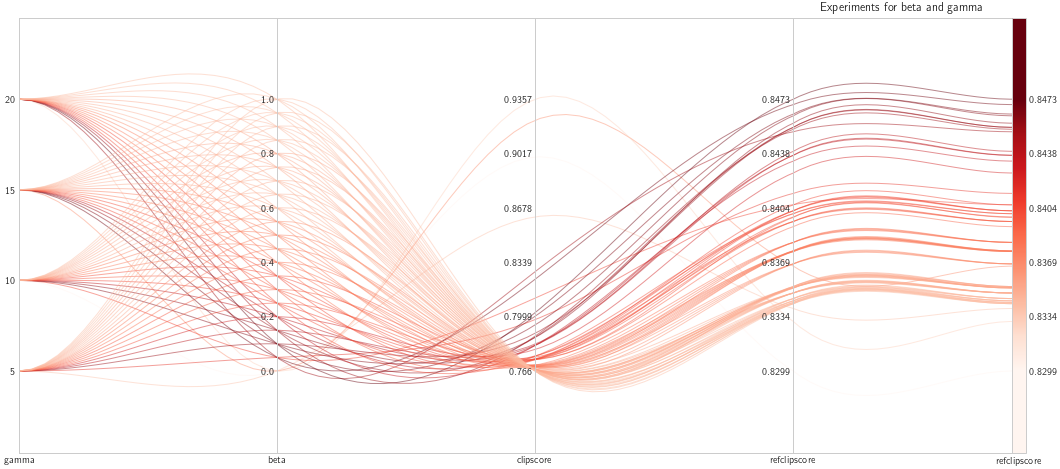

In [9]:
with plt.style.context('science'):
    _ = parallel_plot(df,
                  ['gamma', 'beta', 'clipscore', 'refclipscore'],
                  rank_attr = 'refclipscore', title = 'Experiments for beta and gamma', 
                  curved = True, cmap = 'Reds', curvedextend = 0.3,
                  output = './plots/beta_gamma_parallel_plot.png')

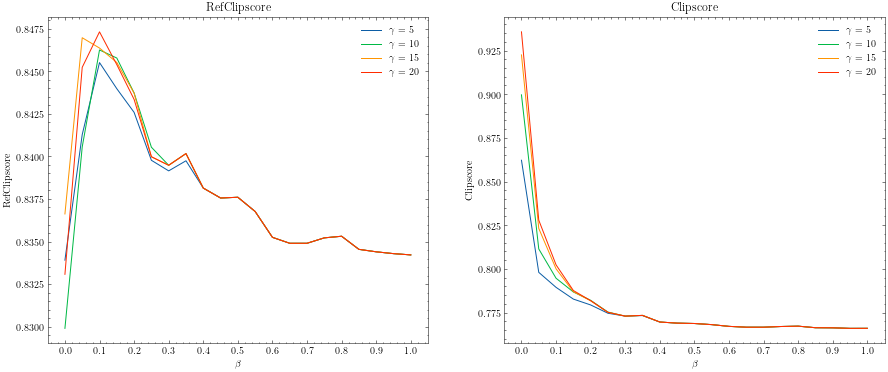

In [21]:
with plt.style.context('science'):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 6))

    ax1.plot(df.loc[df['gamma'] == 5]['beta'], df.loc[df['gamma'] == 5]['refclipscore'], label = '$\gamma$ = 5' )
    ax1.plot(df.loc[df['gamma'] == 10]['beta'], df.loc[df['gamma'] == 10]['refclipscore'], label = '$\gamma$ = 10' )
    ax1.plot(df.loc[df['gamma'] == 15]['beta'], df.loc[df['gamma'] == 15]['refclipscore'], label = '$\gamma$ = 15' )
    ax1.plot(df.loc[df['gamma'] == 20]['beta'], df.loc[df['gamma'] == 20]['refclipscore'], label = '$\gamma$ = 20' )
    ax1.set_xticks(np.arange(0, 1.05, 0.1)) 
    ax1.set_xlabel(r'$\beta$')
    ax1.set_ylabel('RefClipscore')
    ax1.set_title('RefClipscore')
    ax1.legend()

    ax2.plot(df.loc[df['gamma'] == 5]['beta'], df.loc[df['gamma'] == 5]['clipscore'], label = '$\gamma$ = 5' )
    ax2.plot(df.loc[df['gamma'] == 10]['beta'], df.loc[df['gamma'] == 10]['clipscore'], label = '$\gamma$ = 10' )
    ax2.plot(df.loc[df['gamma'] == 15]['beta'], df.loc[df['gamma'] == 15]['clipscore'], label = '$\gamma$ = 15' )
    ax2.plot(df.loc[df['gamma'] == 20]['beta'], df.loc[df['gamma'] == 20]['clipscore'], label = '$\gamma$ = 20' )
    ax2.set_xticks(np.arange(0, 1.05, 0.1)) 
    ax2.set_xlabel(r'$\beta$')
    ax2.set_ylabel('Clipscore')
    ax2.set_title('Clipscore')
    ax2.legend()
    fig.savefig('./plots/clipscore_refclipscore.jpg', dpi=300)
    plt.show() 